In [88]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
from scipy.signal import savgol_filter

In [89]:
def create_time_data(start_time, end_time, time_delta):
    
    timestamps = []
    current_time = start_time
    while current_time <= end_time:
        timestamps.append(current_time)
        current_time += time_delta
        
    return timestamps

def create_base_consumption(timestamps, base_consumption_metadata):
    t = np.linspace(0, (timestamps[-1]-timestamps[0])/timedelta(hours=1), len(timestamps))
    n_points = len(t)
    base_consumption = np.ones(n_points) * base_consumption_metadata["mean_base"]

    for peak in base_consumption_metadata["peaks"]:
        peak_consumption = np.zeros_like(timestamps)
        mask = [(timestamp>=peak["start"]) & (timestamp<=peak["end"]) for timestamp in timestamps]
        t_normalized = (t[mask] - np.min(t[mask])) / (np.max(t[mask]) - np.min(t[mask]))
        peak_consumption[mask] = peak["peak"] * np.sin(np.pi * t_normalized )
        base_consumption = base_consumption + peak_consumption
    
    
    # Combine, add noise and smooth
    base_consumption += np.random.normal(0, 0.05, n_points)
    base_consumption = savgol_filter(base_consumption, window_length=5, polyorder=3)
    
    return np.abs(base_consumption)

def create_solar_production(timestamps, solar_production_metadata):
    t = np.linspace(0, (timestamps[-1]-timestamps[0])/timedelta(hours=1), len(timestamps))
    solar_production = np.zeros_like(t)
    for solar_production_peak in solar_production_metadata["peaks"]:
        t_normalized = t
        mask = [(timestamp>=solar_production_peak["start"]) & (timestamp<=solar_production_peak["end"]) for timestamp in timestamps]
        t_normalized = (t[mask] - np.min(t[mask])) / (np.max(t[mask]) - np.min(t[mask]))
        t_peak = np.mean(t[mask])
 
        solar_production[mask] = solar_production[mask] + (-solar_production_peak["peak"] * np.sin(np.pi * t_normalized) * np.exp(-((t[mask] - t_peak) ** 2) / 8))
    
    return -np.abs(solar_production)


In [90]:
def strategy_scheduled(timestamps, cet_properties, scheduling_strategy_metadata):
    """Strategy 1: Scheduling: The CET is triggered at a constant time period"""
    cet_consumption = np.zeros_like(timestamps)
    for schedule in scheduling_strategy_metadata:
        cet_mask = [(t >= schedule["start"]) & (t < schedule["end"]) for t in timestamps]
        cet_consumption[cet_mask] = cet_properties["power"]
    
    return cet_consumption

def strategy_solar_only(timestamps, solar_production, base_consumption, cet_properties, solar_only_strategy_metadata):
    """Strategy 2: CET runs only if it is 100% powered by the solar production
                Activation trigger  : there is enough available solar power (prod-consumption) to cover the CET consumption
                Deactivation trigger: power from the grid is necessary to run the CET (= available solar power < 0)
    """
    cet_consumption = np.zeros_like(timestamps)
    threshold_start = cet_properties["power"]*solar_only_strategy_metadata["threshold_start"]

    # Grid exchange > 0: solar production does not cover the total consumption & power from the grid is necessary
    # Grid exchange < 0: solar production coveres all the consumption & solar production is injected to the grid
    grid_exchange = base_consumption + solar_production
    
    # Initialize the loop parameters
    state_duration = timedelta(minutes=0)           # Used to make sure the minimum duration of each state is respected
    total_running_duration = timedelta(minutes=0)   # Used to make sure the device does not last more than necessary
    state_init_timestamp = timestamps[0]
    is_running = False
    

    for i in range(len(timestamps)):
        
        state_duration = timestamps[i] - state_init_timestamp
        # CET is running        
        if is_running:
            
            # Add the CET consumption to the grid exchange as the CET is running
            power_from_grid = grid_exchange[i] + cet_properties["power"]
            
            # Stop condition #1 because CET has run long enough to heat water. All future CET values are null
            if (total_running_duration + state_duration) >= cet_properties["max_duration"]:
                total_running_duration = cet_properties["max_duration"]
                break

            # Stop condition #2 because energy is taken from the grid.
            if power_from_grid > 0 and state_duration >= cet_properties["min_duration"]:
                total_running_duration += state_duration
                is_running = False
                state_init_timestamp = timestamps[i] # new state initial timestamp

            # Otherwise, continue running (either for min_duration reason or enough production)
            else:
                cet_consumption[i] = cet_properties["power"]
                state_duration = timestamps[i] - state_init_timestamp

        # CET is off
        else:
            
            # Available solar power
            available_solar_power = -grid_exchange[i]
            # Start condition = enough solar production to cover the CET consumption and min_duration limit is exceeded
            if available_solar_power >= threshold_start and state_duration >= cet_properties["min_duration"]:
                is_running = True
                state_init_timestamp = timestamps[i] # new state initial timestamp
                cet_consumption[i] = cet_properties["power"]

    state_duration = timedelta(minutes=0)
    state_end_timestamp = timestamps[-1]
    i = 1
    while (total_running_duration + state_duration) < cet_properties["max_duration"]:
        cet_consumption[-i] = cet_properties["power"]
        i+=1
        state_duration = state_end_timestamp - timestamps[-(i)]

    return cet_consumption

def strategy_maximize_solar(timestamps, solar_production, base_consumption, cet_properties, max_solar_strategy_metadata):
    """Strategy 3: Maximizing self-consumption
                Activation trigger  : There is solar over-production (grid_exchange < 0)
                Deactivation trigger: No solar production is used to power the CET
    """
    cet_consumption = np.zeros_like(timestamps)
    
    # Grid exchange > 0: solar production does not cover the total consumption & power from the grid is necessary
    # Grid exchange < 0: solar production coveres all the consumption & solar production is injected to the grid
    grid_exchange = base_consumption + solar_production

    # Initialize the loop parameters
    state_duration = timedelta(minutes=0)           # Used to make sure the minimum duration of each state is respected
    total_running_duration = timedelta(minutes=0)   # Used to make sure the device does not last more than necessary
    state_init_timestamp = timestamps[0]
    is_running = False
    
    for i in range(len(timestamps)):
        
        state_duration = timestamps[i] - state_init_timestamp
        power_from_grid_without_cet = grid_exchange[i]

        # CET is running        
        if is_running:

            # Stop condition #1 because CET has run long enough to heat water. All future CET values are null
            if (total_running_duration + state_duration) >= cet_properties["max_duration"]:
                total_running_duration = cet_properties["max_duration"]
                break

            # Stop condition #2 because solar production covers less than a percentage of the CET consumption
            if (power_from_grid_without_cet) > 0 and state_duration >= cet_properties["min_duration"]:
                total_running_duration += state_duration
                is_running = False
                state_init_timestamp = timestamps[i] # new state initial timestamp

            # Otherwise, continue running (either for min_duration reason or enough production)
            else:
                cet_consumption[i] = cet_properties["power"]
                state_duration = timestamps[i] - state_init_timestamp

        # CET is off
        else:

            # Available solar power
            available_solar_power = -power_from_grid_without_cet
            # Start condition = CET will be at least partially powered by the solar production and min_duration limit is exceeded
            if available_solar_power >= 0 and state_duration >= cet_properties["min_duration"]:
                is_running = True
                state_init_timestamp = timestamps[i] # new state initial timestamp
                cet_consumption[i] = cet_properties["power"]

    state_duration = timedelta(minutes=0)
    state_end_timestamp = timestamps[-1]
    i = 1
    while (total_running_duration + state_duration) < cet_properties["max_duration"]:
        cet_consumption[-i] = cet_properties["power"]
        i+=1
        state_duration = state_end_timestamp - timestamps[-(i)]
    
    return cet_consumption


def strategy_optim(timestamps, solar_production, base_consumption, cet_properties, optim_strategy_metadata):
    """Strategy 4: Bill optimization
                Activation trigger  : self-consumption ratio > rentability threshold (i.e., better use the production than selling it to the grid)
                Deactivation trigger: self-consumption ratio < rentability threshold
    """
    cet_consumption = np.zeros_like(timestamps)

    # Initialize the loop parameters
    state_duration = timedelta(minutes=0)           # Used to make sure the minimum duration of each state is respected
    total_running_duration = timedelta(minutes=0)   # Used to make sure the device does not last more than necessary
    state_init_timestamp = timestamps[0]
    is_running = False
    
    for i in range(len(timestamps)):
        
        state_duration = timestamps[i] - state_init_timestamp
        self_consumption_ratio_with_cet = abs(solar_production[i])/(base_consumption[i] + cet_properties["power"])

        # CET is running        
        if is_running:

            # Stop condition #1 because CET has run long enough to heat water. All future CET values are null
            if (total_running_duration + state_duration) >= cet_properties["max_duration"]:
                total_running_duration = cet_properties["max_duration"]
                break

            # Stop condition #2 because the rentability threshold is no longer reached
            if self_consumption_ratio_with_cet <= optim_strategy_metadata["threshold"] and state_duration >= cet_properties["min_duration"]:
                total_running_duration += state_duration
                is_running = False
                state_init_timestamp = timestamps[i] # new state initial timestamp

            # Otherwise, continue running (either for min_duration reason or enough production)
            else:
                cet_consumption[i] = cet_properties["power"]
                state_duration = timestamps[i] - state_init_timestamp

        # CET is off
        else:

            # Start condition = the rentability threshold is reached
            if self_consumption_ratio_with_cet >= optim_strategy_metadata["threshold"] and state_duration >= cet_properties["min_duration"]:
                is_running = True
                state_init_timestamp = timestamps[i] # new state initial timestamp
                cet_consumption[i] = cet_properties["power"]
    
    state_duration = timedelta(minutes=0)
    state_end_timestamp = timestamps[-1]
    i = 1
    while (total_running_duration + state_duration) < cet_properties["max_duration"]:
        cet_consumption[-i] = cet_properties["power"]
        i+=1
        state_duration = state_end_timestamp - timestamps[-(i)]
        
    return cet_consumption


In [91]:
def calculate_metrics(timestamps, solar_production, home_consumption, grid_exchanges, cet_consumption):
    """Calcule les métriques de performance pour une stratégie donnée"""
    
    ## Delta between 2 timestamps in hours
    dt_hours = (timestamps[1]-timestamps[0]).total_seconds() / 3600
    consumption_from_grid_ratio = np.zeros_like(timestamps)
    consumption_from_solar_ratio = np.zeros_like(timestamps)
    self_consumption_ratio = np.zeros_like(timestamps)
    grid_exports = np.zeros_like(timestamps)
    grid_imports = np.zeros_like(timestamps)
    cet_active = np.zeros_like(timestamps)


    
    ## Compute total solar production & home consumption
    total_solar_production = -np.sum(solar_production) * dt_hours  # kWh
    total_home_consumption = np.sum(home_consumption) * dt_hours  # kWh
    
    ## Compute Energy imported from/exported to the grid
    mask_export = grid_exchanges<0
    mask_import = grid_exchanges>0
    grid_exports[mask_export] = -grid_exchanges[mask_export]
    grid_imports[mask_import] = grid_exchanges[mask_import]
    total_grid_imports = np.sum(grid_imports) * dt_hours  # kWh
    total_grid_exports = np.sum(grid_exports) * dt_hours  # kWh


    
    ## Compute grid & solar consumption ratio (share of home consumption coming from the grid or the solar production)
    # Only when grid exchanges are positive, otherwise power comes only from the solar production
    consumption_from_grid_ratio = grid_imports/home_consumption
    
    # When grid exchanges are negative, 100% of home consumption is covered by the grid
    # Otherwise, the solar production partially covers the home consumption
    consumption_from_solar_ratio[mask_export] = 1.
    consumption_from_solar_ratio[mask_import] = (-solar_production[mask_import])/home_consumption[mask_import]
    
    
    self_consumption_ratio[mask_export] = (-solar_production[mask_export] - grid_exports[mask_export])/ (-solar_production[mask_export])
    self_consumption_ratio[mask_import & (solar_production <0)] = 1.

    # Self-consumption = Capacity to consume the solar production
    consumption_from_local_prod = total_solar_production - total_grid_exports
    # Self-consumption rate = share of production use for consumption
    self_consumption_rate = (consumption_from_local_prod / total_solar_production * 100) if total_solar_production > 0 else 0
    
    # Compute costs
    import_tariff = 0.25
    export_tariff = 0#.1269
    grid_kWh_price = consumption_from_grid_ratio*import_tariff
    cet_consumption_price = grid_kWh_price*cet_consumption*dt_hours
    home_consumption_price = grid_kWh_price*home_consumption*dt_hours

    import_cost = total_grid_imports * import_tariff  # 0.25€/kWh for importing energy from the grid
    export_revenue = total_grid_exports * export_tariff  # 0.1269€/kWh for exporting solar energy to the grid
    total_cost = import_cost - export_revenue
    mean_cost_per_kwh = total_cost/total_home_consumption
    total_cet_cost = np.sum(cet_consumption_price)
    cet_active[cet_consumption>0] = 1
    cet_solar_ratio = np.sum((1-consumption_from_grid_ratio)*cet_consumption)/np.sum(cet_consumption)*100
    
    # Calcul du temps de fonctionnement du CET
    cet_runtime_points = np.sum(cet_consumption > 0)  # Nombre de points où le CET fonctionne
    cet_runtime_hours = cet_runtime_points * dt_hours  # Conversion en heures
    
    return {
        'production_totale': total_solar_production,
        'consommation_totale': total_home_consumption,
        'import_reseau': total_grid_imports,
        'export_reseau': total_grid_exports,
        'taux_autoconsommation': self_consumption_rate,
        'cout_total': total_cost,
        'cout_moyen_kwh': mean_cost_per_kwh,
        'cout_import': import_cost,
        'revenu_export': export_revenue,
        'temps_fonctionnement_cet': cet_runtime_hours,
        'cout_fonctionnement_cet': total_cet_cost,
        'cet_active':cet_active,
        'cet_solar_share':cet_solar_ratio
    }

In [92]:
def plot_results(timestamps, base_consumption, solar_production, cet_consumptions, time_delta):
    strategies = ['Programmé la nuit', 'Programmé en journée', '100% Solaire', 'Max. Solar.','Optimiz']
    fig = plt.figure(figsize=(15, 15))
    
    # Création d'une grille de sous-graphiques
    gs = plt.GridSpec(6, 1, height_ratios=[3, 3, 3, 3, 3, 3], hspace=1)
    
    # Création des graphiques de puissance
    axs = [fig.add_subplot(gs[i]) for i in range(5)]
    
    # Liste pour stocker les métriques de chaque stratégie
    all_metrics = []
    
    for idx, (strategy_name, cet_consumption) in enumerate(zip(strategies, cet_consumptions)):
        ax = axs[idx]
        home_consumption = base_consumption + cet_consumption
        grid_exchanges = home_consumption + solar_production
        
        # Calcul des métriques
        metrics = calculate_metrics(timestamps, solar_production, home_consumption, grid_exchanges, cet_consumption)
        all_metrics.append(metrics)
        
        # Affichage des courbes
        width = time_delta.total_seconds() / (3600 * 24)
        ax.bar(timestamps, home_consumption, width, label='Consommation', color='#FF6B6B', alpha=0.7)
        ax.bar(timestamps, solar_production, width, label='Production solaire', color='#4ECB71', alpha=0.7)
        ax.plot(timestamps, grid_exchanges, 'b-', label='Échanges réseau', linewidth=2)
        ax.plot(timestamps, metrics["cet_active"], 'r-', label='CET actif', linewidth=2)
        
        ax.set_xlabel('Heure')
        ax.set_ylabel('Puissance (kW)')
        ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))
        plt.setp(ax.get_xticklabels(), rotation=45)
        ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
        ax.legend(loc='upper right')
        ax.set_title(f'Stratégie: {strategy_name}')
        ax.set_ylim(-3, 3)
    
    # Ajout d'un tableau comparatif des métriques
    ax_table = fig.add_subplot(gs[5])
    ax_table.axis('tight')
    ax_table.axis('off')
    
    # Préparation des données pour le tableau
    table_data = [
        ['Métrique'] + strategies,
        ['Import réseau (kWh)', 
         f"{all_metrics[0]['import_reseau']:.2f}",
         f"{all_metrics[1]['import_reseau']:.2f}",
         f"{all_metrics[2]['import_reseau']:.2f}",
         f"{all_metrics[3]['import_reseau']:.2f}",
         f"{all_metrics[4]['import_reseau']:.2f}"],
        ['Export réseau (kWh)', 
         f"{all_metrics[0]['export_reseau']:.1f}",
         f"{all_metrics[1]['export_reseau']:.1f}",
         f"{all_metrics[2]['export_reseau']:.1f}",
         f"{all_metrics[3]['export_reseau']:.1f}",
         f"{all_metrics[4]['export_reseau']:.1f}"],
        ['Taux autoconsommation (%)', 
         f"{all_metrics[0]['taux_autoconsommation']:.2f}%",
         f"{all_metrics[1]['taux_autoconsommation']:.2f}%",
         f"{all_metrics[2]['taux_autoconsommation']:.2f}%",
         f"{all_metrics[3]['taux_autoconsommation']:.2f}%",
         f"{all_metrics[4]['taux_autoconsommation']:.2f}%"],
        ['Coût total (€)', 
         f"{all_metrics[0]['cout_total']:.2f}",
         f"{all_metrics[1]['cout_total']:.2f}",
         f"{all_metrics[2]['cout_total']:.2f}",
         f"{all_metrics[3]['cout_total']:.2f}",
         f"{all_metrics[4]['cout_total']:.2f}"],
         ['Cout moyen/kWh (€/kWh)', 
         f"{all_metrics[0]['cout_moyen_kwh']:.3f}",
         f"{all_metrics[1]['cout_moyen_kwh']:.3f}",
         f"{all_metrics[2]['cout_moyen_kwh']:.3f}",
         f"{all_metrics[3]['cout_moyen_kwh']:.3f}",
         f"{all_metrics[4]['cout_moyen_kwh']:.3f}"],
         ['Cout Cet (€)', 
         f"{all_metrics[0]['cout_fonctionnement_cet']:.2f}",
         f"{all_metrics[1]['cout_fonctionnement_cet']:.2f}",
         f"{all_metrics[2]['cout_fonctionnement_cet']:.2f}",
         f"{all_metrics[3]['cout_fonctionnement_cet']:.2f}",
         f"{all_metrics[4]['cout_fonctionnement_cet']:.2f}"],
         ['CET solar ratio (%)', 
         f"{all_metrics[0]['cet_solar_share']:.2f}%",
         f"{all_metrics[1]['cet_solar_share']:.2f}%",
         f"{all_metrics[2]['cet_solar_share']:.2f}%",
         f"{all_metrics[3]['cet_solar_share']:.2f}%",
         f"{all_metrics[4]['cet_solar_share']:.2f}%"]
    ]
    
    table = ax_table.table(cellText=table_data, loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)
    
    # Mise en forme du tableau
    for (row, col), cell in table.get_celld().items():
        if row == 0:
            cell.set_text_props(weight='bold')
            cell.set_facecolor('#E6E6E6')
        elif col == 0:
            cell.set_text_props(weight='bold')
    
    plt.tight_layout()
    return fig, all_metrics

/var/folders/ts/9vfhl4251kd__twtz_zx5plsb57dt2/T/ipykernel_77602/1133082944.py:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


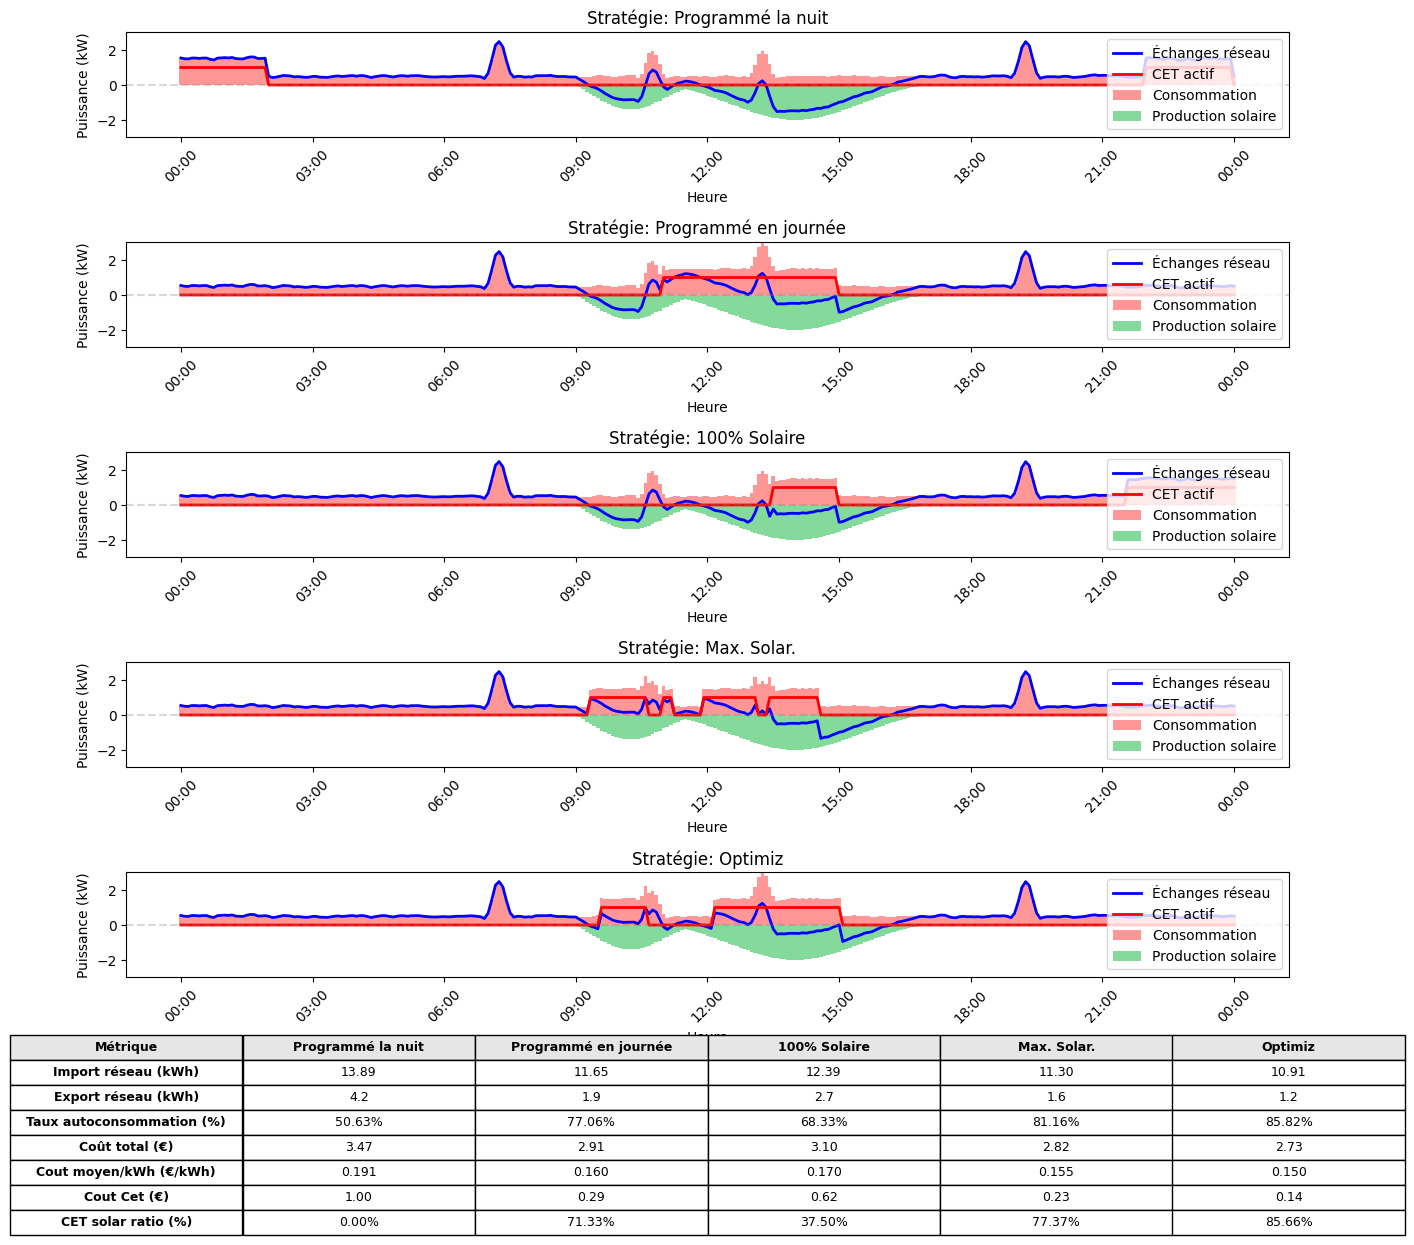

In [93]:
def main():
    # Création des données temporelles
    # 24h data
    start_time = datetime(2024, 1, 1, 0, 0)
    end_time = datetime(2024, 1, 2, 0, 0)
    time_delta = timedelta(minutes=5)
    timestamps = create_time_data(start_time, end_time, time_delta)
    
    # Création des données de base
    base_consumption_metadata = {
        "mean_base": 0.5,     #kW

        "peaks":[
        {
            "name": "morning_peak",
            "peak":2,                           #kW
            "start":datetime(2024, 1, 1, 7, 0), #h:mm
            "end":datetime(2024, 1, 1, 7, 30)   #h:mm
        },
        {
            "name": "evening_peak",
            "peak":2,       #kW
            "start":datetime(2024, 1, 1, 19, 0),#h:mm
            "end":datetime(2024, 1, 1, 19, 30)   #h:mm
        },
        {
            "name": "lunch",
            "peak":1.5,       #kW
            "start":datetime(2024, 1, 1, 13, 0),#h:mm
            "end":datetime(2024, 1, 1, 13, 30)  #h:mm
        },
        {
            "name": "Washing machine",
            "peak":1.5,       #kW
            "start":datetime(2024, 1, 1, 10, 30),#h:mm
            "end":datetime(2024, 1, 1, 11, 00)  #h:mm
        }]
        
        
    }
    

    solar_production_metadata = {
        "peaks":
        [
            {
                "peak": 1.4,     #kW
                "start":datetime(2024, 1, 1, 9, 0), #h:mm
                "end":datetime(2024, 1, 1, 11, 30)    #h:mm
            },
            {
                "peak": 2,     #kW
                "start":datetime(2024, 1, 1, 11, 0), #h:mm
                "end":datetime(2024, 1, 1, 17, 0)    #h:mm
            }
        ]
    }
    
    base_consumption = create_base_consumption(timestamps, base_consumption_metadata)
    solar_production = create_solar_production(timestamps, solar_production_metadata)
    
    # Application des trois stratégies
    cet_properties = {
        "power": 1, #kw
        "min_duration": timedelta(minutes = 15),
        "max_duration": timedelta(hours = 4)
    }
    
    strategies = {
        "night_scheduling":[
            {
                "start":datetime(2024, 1, 1, 0, 0),  # 11h
                "end":datetime(2024, 1, 1, 2, 0),  # 11h
            },
            {
                "start":datetime(2024, 1, 1, 22, 0),  # 11h
                "end":datetime(2024, 1, 2, 0, 0),  # 11h
            }
        ],
        "day_scheduling":[
            {
                "start":datetime(2024, 1, 1, 11, 0),  # 11h
                "end":datetime(2024, 1, 1, 15, 0),  # 11h
            }
        ],
        "solar_only":{
            "threshold_start": 1.1, # 110% of CET consumption
            "threshold_stop": 0
        },
        "max_solar":{
            "threshold_stop": 1
        },
        "cost_optimization":
        {
            "threshold": 0.5
        }

    }

    
    cet_night_scheduled = strategy_scheduled(timestamps, cet_properties, strategies["night_scheduling"])
    cet_day_scheduled = strategy_scheduled(timestamps, cet_properties, strategies["day_scheduling"])
    cet_solar_only = strategy_solar_only(timestamps, solar_production, base_consumption, cet_properties, strategies["solar_only"])
    cet_maximize = strategy_maximize_solar(timestamps, solar_production, base_consumption, cet_properties, strategies["max_solar"])
    cet_optimize = strategy_optim(timestamps, solar_production, base_consumption, cet_properties, strategies["cost_optimization"])
    
    # Création du graphique comparatif avec métriques
    fig, metrics = plot_results(
        timestamps,
        base_consumption,
        solar_production,
        [cet_night_scheduled, cet_day_scheduled, cet_solar_only, cet_maximize, cet_optimize],
        time_delta
    )
    
    plt.show()

if __name__ == "__main__":
    main()